In [31]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd


QUERY_URLS = [
    "http://localhost:8983/solr/movies/select?defType=edismax&indent=true&q.op=OR&q=%22plot%20twist%22~3&qf=keywords%20reviews%20description&rows=30",
    "http://localhost:8983/solr/movies/select?defType=edismax&indent=true&q.op=OR&q=%22based%20true%20story%22~3&qf=keywords%20reviews%20description&rows=30",
    "http://localhost:8983/solr/movies/select?defType=edismax&indent=true&q.op=OR&q=%22bad%20script%22~3&qf=keywords%20reviews%20description&rows=30",
]

QUERYS = [
    "poor script",
    "based true story",
    "plot twist",
]

In [51]:
req = requests.get(QUERY_URLS[1]).json()['response']['docs']

with open("results/stage2/query2.txt", "w") as f:
    for r in req:
        f.write(r['title'] + "\n")

In [54]:
def evaluate(stage):
    for i in range(1, 2):
        # Read qrels to extract relevant documents
        relevant = list(map(lambda el: el.strip(), open(f"results/stage{stage}/query{i+1}.txt").readlines()))
        # Get query results from Solr instance

        req = requests.get(QUERY_URLS[i]).json()
    
        results = req['response']['docs']

        print(req["response"]["numFound"])

        # METRICS TABLE
        # Define custom decorator to automatically calculate metric based on key
        metrics = {}
        metric = lambda f: metrics.setdefault(f.__name__, f)

        @metric
        def ap(results, relevant):
            """Average Precision"""
            precision_values = [
                len([
                    doc 
                    for doc in results[:idx]
                    if doc['title'] in relevant
                ]) / idx 
                for idx in range(1, len(results))
            ]
            return sum(precision_values)/len(precision_values)

        @metric
        def p30(results, relevant, n=30):
            """Precision at N"""
            return len([doc for doc in results[:n] if doc['title'] in relevant])/n

        def calculate_metric(key, results, relevant):
            return metrics[key](results, relevant)

        # Define metrics to be calculated
        evaluation_metrics = {
            'ap': 'Average Precision',
            'p30': 'Precision at 30 (P@30)'
        }

        # Calculate all metrics and export results as LaTeX table
        df = pd.DataFrame([['Metric','Value']] +
            [
                [evaluation_metrics[m], calculate_metric(m, results, relevant)]
                for m in evaluation_metrics
            ]
        )

        with open(f'results/stage{stage}/query{i+1}.tex','w') as tf:
            tf.write(df.to_latex())

        # PRECISION-RECALL CURVE
        # Calculate precision and recall values as we move down the ranked list
        precision_values = [
            len([
                doc 
                for doc in results[:idx]
                if doc['title'] in relevant
            ]) / idx 
            for idx, _ in enumerate(results, start=1)
        ]

        recall_values = [
            len([
                doc for doc in results[:idx]
                if doc['title'] in relevant
            ]) / len(relevant)
            for idx, _ in enumerate(results, start=1)
        ]

        precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

        # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
        recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
        recall_values = sorted(set(recall_values))

        # Extend matching dict to include these new intermediate steps
        for idx, step in enumerate(recall_values):
            if step not in precision_recall_match:
                if recall_values[idx-1] in precision_recall_match:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
                else:
                    precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

        disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
        disp.plot()
        plt.savefig(f'plots/stage{stage}/query{i+1}.pdf')    


297


C:\Users\veris\AppData\Local\Temp\ipykernel_20188\1300244119.py:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())


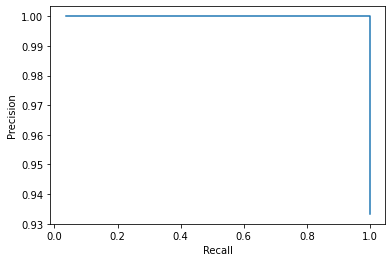

In [55]:
for stage in range(2,3):
    evaluate(stage)